In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load

In [2]:
#proton_selection = "SingleRP"
proton_selection = "MultiRP"

In [3]:
def get_data( fileNames ):
    df_list = []
    df_counts_list = []

    for file_ in fileNames:
        print ( file_ )
        with h5py.File( file_, 'r' ) as f:
            print ( list(f.keys()) )
            dset = f['protons']
            print ( dset.shape )
            print ( dset[:,:] )

            dset_columns = f['columns']
            print ( dset_columns.shape )
            columns = list( dset_columns )
            print ( columns )
            columns_str = [ item.decode("utf-8") for item in columns ]
            print ( columns_str )

            dset_selections = f['selections']
            selections_ = [ item.decode("utf-8") for item in dset_selections ]
            print ( selections_ )

            dset_counts = f['event_counts']
            df_counts_list.append( pd.Series( dset_counts, index=selections_ ) )
            print ( df_counts_list[-1] )

            chunk_size = 1000000
            entries = dset.shape[0]
            start_ = list( range( 0, entries, chunk_size ) )
            stop_ = start_[1:]
            stop_.append( entries )
            print ( start_ )
            print ( stop_ )
            for idx in range( len( start_ ) ):
                print ( start_[idx], stop_[idx] )
                #print ( dset[ start_[idx] : stop_[idx] ] )
                df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
                df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                            'Xi', 'T', 'ThX', 'ThY', 'Time',
                            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
                df_list.append( df_ )
                print ( df_list[-1].head() )
                print ( len( df_list[-1] ) )

    df_counts = df_counts_list[0]
    for idx in range( 1, len( df_counts_list ) ):
        df_counts = df_counts.add( df_counts_list[idx] )
    print ( df_counts )

    df = pd.concat( df_list )
    print ( df )
    
    return ( df_counts, df )

In [4]:
def process_data( df ):
    msk = ( df["InvMass"] >= 110. )

    msk1 = None
    msk2 = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_arm = ( df["RPId1"] == 23 )
        msk2_arm = ( df["RPId1"] == 123 )
        df[ "XiMuMu" ] = np.nan
        df[ "XiMuMu" ].where( ~msk1_arm, df[ "XiMuMuPlus" ], inplace=True )
        df[ "XiMuMu" ].where( ~msk2_arm, df[ "XiMuMuMinus" ], inplace=True )
        #df_signal[ "XiMuMu" ][ msk2_arm ] = df_signal[ "XiMuMuMinus" ] 
        msk1 = msk & ( df["MultiRP"] == 0) & msk1_arm
        msk2 = msk & ( df["MultiRP"] == 0) & msk2_arm
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_arm = ( df["Arm"] == 0 )
        msk2_arm = ( df["Arm"] == 1 )
        df[ "XiMuMu" ] = np.nan
        df[ "XiMuMu" ].where( ~msk1_arm, df[ "XiMuMuPlus" ], inplace=True )
        df[ "XiMuMu" ].where( ~msk2_arm, df[ "XiMuMuMinus" ], inplace=True )
        msk1 = msk & ( df["MultiRP"] == 1 ) & msk1_arm
        msk2 = msk & ( df["MultiRP"] == 1 ) & msk2_arm

    df = df[ msk1 | msk2 ]
    return ( df )  

## Signal

In [5]:
fileNames_signal = [
    'output/output-MC2017-Elastic-Non3+3-PreSel.h5'
    #'output-MC2017-SingleDissociation-PreSel.h5'
]

df_counts_signal, df_signal = get_data( fileNames_signal ) 

output/output-MC2017-Elastic-Non3+3-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(213536, 38)
[[1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 9.1376482e-04
  2.3529863e-02 4.4119707e-03]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 ...
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 2.6697566e-04
  2.1097749e-03 4.5376737e-02]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP

In [6]:
df_signal = process_data( df_signal )
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
3,1,1,3,150.0,1,1,103,123,7.630859,1.224731,...,0.000023,0.0,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510,0.081510
6,1,1,12,150.0,1,0,3,23,5.149414,0.725220,...,0.000011,0.0,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708,0.055618
16,1,1,17,150.0,1,1,103,123,3.828247,0.749878,...,0.000012,0.0,61.452324,60.853138,263.130524,1,0.000028,0.008177,0.050104,0.050104
19,1,1,30,150.0,1,0,3,23,5.139893,0.158340,...,0.000055,0.0,52.522842,51.576660,176.417725,1,0.001032,0.046055,0.003999,0.046055
24,1,1,13,150.0,1,1,103,123,2.742798,0.001996,...,0.000114,0.0,117.683517,115.790192,233.975662,17,0.000317,0.007711,0.042010,0.042010
27,1,1,31,150.0,1,1,103,123,5.258789,-0.745728,...,0.000083,0.0,84.892128,72.441437,266.681091,0,0.001807,0.006805,0.061971,0.061971
30,1,1,37,150.0,1,0,3,23,4.975342,1.117432,...,-0.000015,0.0,69.889496,66.498047,176.964508,0,0.000757,0.054292,0.003414,0.054292
42,1,1,52,150.0,1,0,3,23,7.566895,0.678040,...,0.000004,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.072588
43,1,1,52,150.0,1,1,103,123,11.388184,3.717285,...,-0.000008,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.175365
46,1,1,57,150.0,1,1,103,123,3.813232,1.491821,...,-0.000037,0.0,58.605152,56.575214,115.234695,0,0.000651,0.001538,0.051120,0.051120


## Background

In [7]:
resample_factor = 20

fileNames_bkg = [
    'output/output-UL2017B-PreSel-Rnd-Res20.h5',
    'output/output-UL2017C1-PreSel-Rnd-Res20.h5',
    'output/output-UL2017E-PreSel-Rnd-Res20.h5',
    'output/output-UL2017F1-PreSel-Rnd-Res20.h5'
]

df_counts_bkg, df_bkg = get_data( fileNames_bkg )

output/output-UL2017B-PreSel-Rnd-Res20.h5
['columns', 'event_counts', 'protons', 'selections']
(2141500, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', 

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  300122          415  570926592          140.0        0 -999    123     -1   
1  300122          416  571369216          140.0        0 -999      3     -1   
2  300122          416  571369216          140.0        0 -999     23     -1   
3  300122          416  571369216          140.0        1    0      3     23   
4  300122          416  572466240          140.0        0 -999      3     -1   

     TrackX1   TrackY1  ...       ThX       ThY       Time     Muon0Pt  \
0   9.383057  1.225342  ...  0.000000 -0.000021   0.000000   55.057022   
1  11.913086 -0.142517  ...  0.000000  0.000003   0.000000  179.096024   
2  12.124268 -0.293976  ...  0.000000  0.000006   0.000000  179.096024   
3  11.913086 -0.142517  ...  0.000041  0.000064 -11.986328  179.096024   
4  11.683105  2.293457  ...  0.000000 -0.000053   0.000000   66.068581   

     Muon1Pt    InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  

      Run  LumiSection    EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  303885         1645  2018875648          120.0        0 -999    103     -1   
1  303885         1645  2018875648          120.0        0 -999    123     -1   
2  303885         1645  2018875648          120.0        0 -999    123     -1   
3  303885         1645  2018875648          120.0        1    1    103    123   
4  303885         1645  2018397056          120.0        0 -999     23     -1   

    TrackX1   TrackY1  ...       ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0  7.848633 -5.160156  ...  0.000000  0.000121   0.0  57.697025  51.843395   
1  2.449066  1.137573  ...  0.000000 -0.000155   0.0  57.697025  51.843395   
2  7.697876 -5.572754  ...  0.000000  0.000122   0.0  57.697025  51.843395   
3  7.848633 -5.160156  ... -0.000014  0.000207   0.0  57.697025  51.843395   
4  6.934448 -0.428101  ...  0.000000  0.000018   0.0  68.394821  51.546791   

      InvMass  ExtraPfCands     Acopl  XiMuM

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  304333          461  687495744          140.0        0 -999    123     -1   
1  304333          461  687920512          140.0        0 -999     23     -1   
2  304333          461  686286592          140.0        0 -999     23     -1   
3  304333          461  686286592          140.0        0 -999    103     -1   
4  304333          461  686286592          140.0        0 -999    123     -1   

     TrackX1   TrackY1  ...  ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0   8.035645  5.287598  ...  0.0 -0.000136   0.0  96.052330  82.202934   
1   3.535950  0.224518  ...  0.0 -0.000032   0.0  51.174171  50.339672   
2  11.205444  1.933716  ...  0.0 -0.000044   0.0  60.115364  52.360268   
3  13.394043  2.399658  ...  0.0 -0.000029   0.0  60.115364  52.360268   
4  13.453735  2.523926  ...  0.0 -0.000028   0.0  60.115364  52.360268   

      InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  176.20

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  305045          267  469638752          140.0        0 -999      3     -1   
1  305045          267  469638752          140.0        0 -999     23     -1   
2  305045          267  469638752          140.0        0 -999     23     -1   
3  305045          267  469638752          140.0        0 -999     23     -1   
4  305045          267  469638752          140.0        0 -999    123     -1   

     TrackX1   TrackY1  ...  ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0  14.951172 -6.053223  ...  0.0  0.000098   0.0  65.492645  59.079914   
1  15.361694 -6.590332  ...  0.0  0.000098   0.0  65.492645  59.079914   
2  24.503662 -6.944336  ...  0.0  0.000062   0.0  65.492645  59.079914   
3  24.542480 -8.797852  ...  0.0  0.000079   0.0  65.492645  59.079914   
4   3.727661  1.714966  ...  0.0 -0.000092   0.0  65.492645  59.079914   

      InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  131.05

In [8]:
df_bkg = process_data( df_bkg )
df_bkg[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
10,297227,56,38791640,120.0,1,0,3,23,7.063232,1.953613,...,-4.635066e-05,0.0,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.002211
20,297227,58,40362008,120.0,1,0,3,23,7.391113,2.280518,...,-1.740635e-05,0.0,80.369690,68.791176,228.323425,10,0.271141,0.028539,0.011619,0.028539
33,297227,60,41478176,120.0,1,0,3,23,6.782959,1.464966,...,-5.399367e-05,0.0,114.150841,93.884605,323.668549,40,0.157789,0.035037,0.018197,0.035037
47,297227,63,44189296,120.0,1,0,3,23,13.382812,-1.072510,...,6.678360e-05,0.0,138.408752,108.538467,245.222839,53,0.008506,0.033806,0.010684,0.033806
69,297227,73,52238048,120.0,1,1,103,123,8.629883,1.481323,...,7.347923e-05,0.0,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333
84,297227,75,53449356,120.0,1,1,103,123,5.546875,1.592651,...,6.509769e-07,0.0,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.007848
93,297227,76,54126336,120.0,1,0,3,23,8.200684,3.784912,...,-7.809676e-05,0.0,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.049092
111,297227,78,55898044,120.0,1,1,103,123,3.611084,1.855103,...,-1.616523e-05,0.0,58.097786,53.140121,126.642601,84,0.273834,0.032531,0.003312,0.003312
118,297227,79,56863080,120.0,1,1,103,123,3.396606,1.380615,...,-2.309114e-05,0.0,61.966732,50.172760,127.597572,21,0.026694,0.001631,0.059633,0.059633
138,297227,86,61943160,120.0,1,0,3,23,7.637451,1.072144,...,-4.634655e-05,0.0,91.612099,71.395660,163.843567,62,0.095938,0.016999,0.009692,0.016999


### Select variables

In [9]:
X_sig = df_signal[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
print ( X_sig[:20] )

X_bkg = df_bkg[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
print ( X_bkg[:20] )

y_sig = np.ones( len(X_sig) )
y_bkg = np.zeros( len(X_bkg) )

X = pd.concat( [X_sig, X_bkg] ) 
y = np.concatenate( [y_sig, y_bkg] )

          Xi     Muon0Pt     Muon1Pt      InvMass  ExtraPfCands     Acopl  \
3   0.079777  115.289131  114.552933   251.395355            16  0.000880   
6   0.058544   55.317619   52.814793   126.690613             4  0.001160   
16  0.052047   61.452324   60.853138   263.130524             1  0.000028   
19  0.045926   52.522842   51.576660   176.417725             1  0.001032   
24  0.041798  117.683517  115.790192   233.975662            17  0.000317   
27  0.073885   84.892128   72.441437   266.681091             0  0.001807   
30  0.055212   69.889496   66.498047   176.964508             0  0.000757   
42  0.076750  299.492554  274.796112  1466.510620             2  0.000317   
43  0.173075  299.492554  274.796112  1466.510620             2  0.000317   
46  0.050896   58.605152   56.575214   115.234695             0  0.000651   
49  0.035757   81.449699   78.220001   183.164261             0  0.000106   
52  0.050420  125.122971  120.272575   246.067749             0  0.000119   

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=True, random_state=42 )

In [11]:
clf = None

load_keras_model = False
# If not using Keras 
train_model = False
save_model = False

if load_keras_model:
    import tensorflow as tf
    from tensorflow import keras
    clf = keras.models.load_model( "model/keras_model.h5" )
else:
    if train_model:
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.ensemble import AdaBoostClassifier
    
        ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier( max_depth=4 ),
            n_estimators = 200,
            algorithm="SAMME.R",
            learning_rate = 0.5)
        ada_clf.fit( X_train, y_train )
        clf = ada_clf
    
        if save_model:
            dump( clf, "model/ada_clf.joblib" )
    else:
        clf = load( "model/ada_clf.joblib" )

print ( clf )
if load_keras_model:
    clf.summary()

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [12]:
#features_ = ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu']
#for name, score in zip( features_, clf.feature_importances_ ):
#    print( name, score )

### Run cross validation

In [13]:
#y_train_scores = clf.decision_function( X_train )
#from sklearn.model_selection import cross_val_score
#y_scores = cross_val_score( clf, X_train, y_train, cv=3, n_jobs=-1)
#print ( y_scores )

### Predict on test set

In [14]:
scaler = None
X_test_scaled = None
y_test_proba = None

if load_keras_model:
    scaler = load( "model/standard_scaler.joblib" )
    print ( scaler )
    X_test_scaled = scaler.transform( X_test )
    print( X_test_scaled )
    y_test_proba = clf.predict( X_test_scaled )
    y_test_proba = y_test_proba.flatten()
else: 
    y_test_proba = clf.predict_proba( X_test )[:,1]

print ( y_test_proba )

[0.11360371 0.14724482 0.03673918 ... 0.15169768 0.15263901 0.08079114]


### Run ROC curve

In [15]:
#print ( y_train_scores[ y_train == 0 ] )
#print ( y_train_scores[ y_train == 1 ] )
#
#fig = plt.figure( figsize=(10,10) )
#range_ = ( y_train_scores.min(), y_train_scores.max() )
#plt.hist( y_train_scores[ y_train == 0 ], color='orange', alpha=0.20, bins=20, range=range_ )
#plt.hist( y_train_scores[ y_train == 1 ], color='skyblue', alpha=0.60, bins=20, range=range_ )

In [16]:
#y_test_proba = clf.predict_proba( X_test )[:,1]

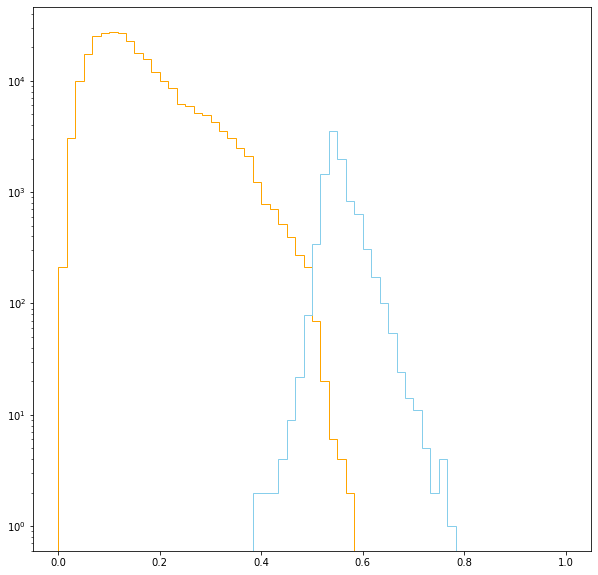

In [17]:
fig = plt.figure( figsize=(10,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='orange', bins=60, range=(0.,1.) )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='skyblue', bins=60, range=(0.,1.) )
plt.yscale('log')

[0.         0.         0.         ... 0.99988717 0.99989469 1.        ] [0.00000000e+00 1.04101603e-04 1.47303768e-01 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [1.7751455  0.7751455  0.58174956 ... 0.01085503 0.01083216 0.00600269]


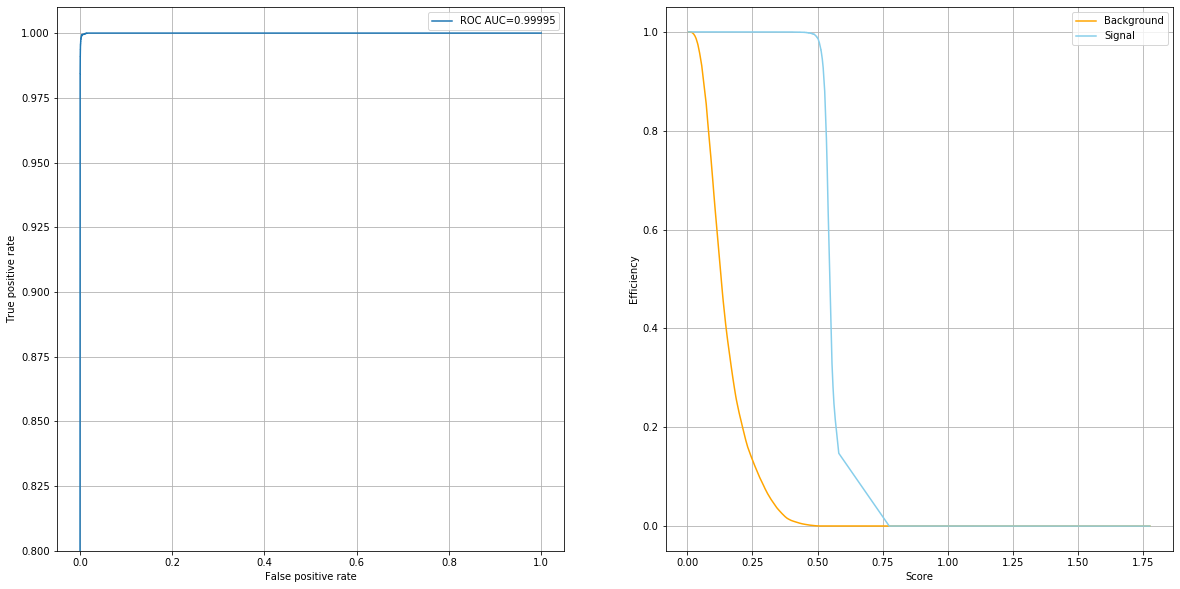

In [18]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve( y_test, y_test_proba )
auc = roc_auc_score(y_test, y_test_proba)

print ( fpr, tpr, thresholds )

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

axes[0].plot(fpr, tpr, label="ROC AUC={:.5f}".format(auc))
axes[0].legend(loc='best')
axes[0].set_xlabel( 'False positive rate' )
axes[0].set_ylabel( 'True positive rate' )
axes[0].set_ylim(0.80,1.01)
axes[0].grid()

#axes[0].plot(tpr,
#             np.divide(np.ones_like(fpr), fpr, out=np.zeros_like(fpr), where=fpr!=0), 
#             label="ROC AUC={:.5f}".format(auc))
#axes[0].legend(loc='best')
#axes[0].set_ylabel('Background rejection (1/false positive rate)')
#axes[0].set_xlabel('Signal efficiency (true positive rate)')
#axes[0].set_xlim(0.88,1.0)
#axes[0].grid()

axes[1].plot(thresholds,fpr,label='Background', color='orange')
axes[1].plot(thresholds,tpr,label='Signal', color='skyblue')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Efficiency')
axes[1].legend()
axes[1].grid()
#axes[1].set_xscale('log')
#axes[1].set_yscale('log')

In [19]:
prob_cut = 0.50
y_test_pred = None

if load_keras_model:
    y_test_pred = ( y_test_proba >= prob_cut ).astype( "int32" )
    y_test_pred = y_test_pred.flatten()
else: 
    y_test_pred = clf.predict( X_test )

print ( y_test_pred )

[0. 0. 0. ... 0. 0. 0.]


In [20]:
from sklearn.metrics import accuracy_score

accuracy_score( y_test, y_test_pred )

0.9991941865276699

(0.0, 0.15)

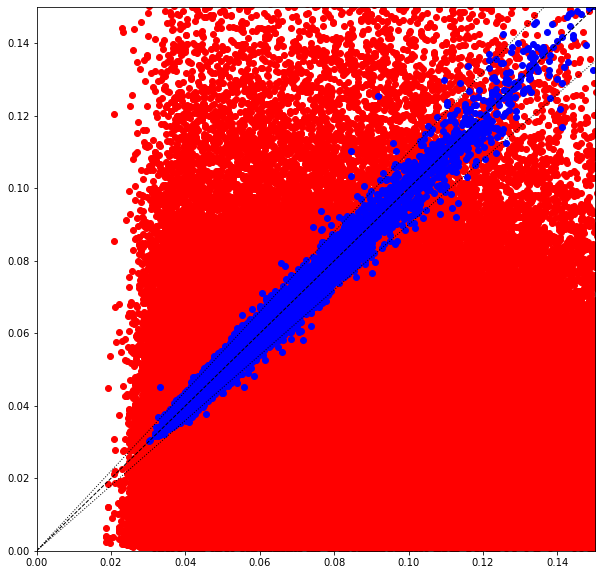

In [21]:
fig= plt.figure( figsize=(10,10) )

msk_bkg = ( y_test_pred == 0 )
msk_sig = ( y_test_pred == 1 )

plt.plot( X_test[ "Xi" ][ msk_bkg ], X_test[ "XiMuMu" ][ msk_bkg ], 'ro' )
plt.plot( X_test[ "Xi" ][ msk_sig ], X_test[ "XiMuMu" ][ msk_sig ], 'bo' )
plt.plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
plt.plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
plt.plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
plt.xlim(0.,0.15)
plt.ylim(0.,0.15)

(array([60.32880016, 63.30511015, 61.8336625 , 59.39244594, 60.02780316,
        54.04175941, 58.9577211 , 58.25541144, 58.22196976, 57.5531026 ,
        52.73756448, 53.9079613 , 52.73756448, 52.40314745, 55.41283615,
        57.08498577, 52.13555314, 57.38596109, 55.31251116, 54.20893627,
        49.49377698, 51.93490316, 50.22937833, 50.93165326, 49.82819439,
        48.18943687, 50.5303533 , 45.88206893, 45.44722047, 45.61442879,
        46.61767869, 45.81518544, 49.66087006, 45.44722047, 46.41702871,
        46.3502533 , 46.24982039, 46.04917041, 47.15285509, 47.11919393,
        41.50120083, 42.3706861 , 41.63477392, 41.76873476, 40.99957471,
        40.09646098, 38.92618676, 40.02957781, 40.2638564 , 42.20347739]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.01

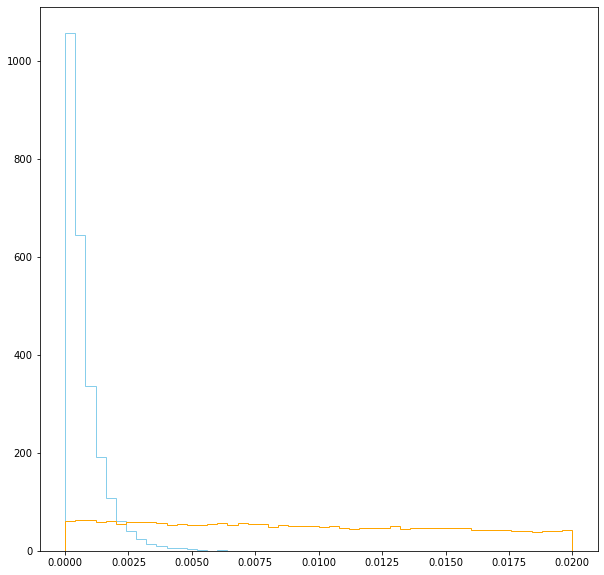

In [22]:
fig = plt.figure( figsize=(10,10) )
plt.hist( X_test[ "Acopl" ][ y_test_pred == 1 ], histtype='step', color='skyblue', bins=50, range=(0.,0.02), density=True )
plt.hist( X_test[ "Acopl" ][ y_test_pred == 0 ], histtype='step', color='orange', bins=50, range=(0.,0.02), density=True )

(array([0.00296225, 0.00277393, 0.00360866, 0.00531882, 0.00668798,
        0.00749216, 0.00933975, 0.01047986, 0.01176249, 0.0136508 ,
        0.01350829, 0.01534061, 0.01650108, 0.01823161, 0.01931064,
        0.01987561, 0.02073578, 0.02237469, 0.02196242, 0.02372348,
        0.02264445, 0.02393216, 0.02332648, 0.02550491, 0.02584592,
        0.02477198, 0.02561179, 0.02658394, 0.02621748, 0.02616149,
        0.02722016, 0.02664502, 0.02661448, 0.02645161, 0.02495012,
        0.02517916, 0.02438515, 0.02384055, 0.02466509, 0.02410013,
        0.02358097, 0.02365223, 0.02221182, 0.02229325, 0.02106153,
        0.02027261, 0.02026243, 0.0198298 , 0.01917831, 0.0373641 ]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 1 Patch objects>)

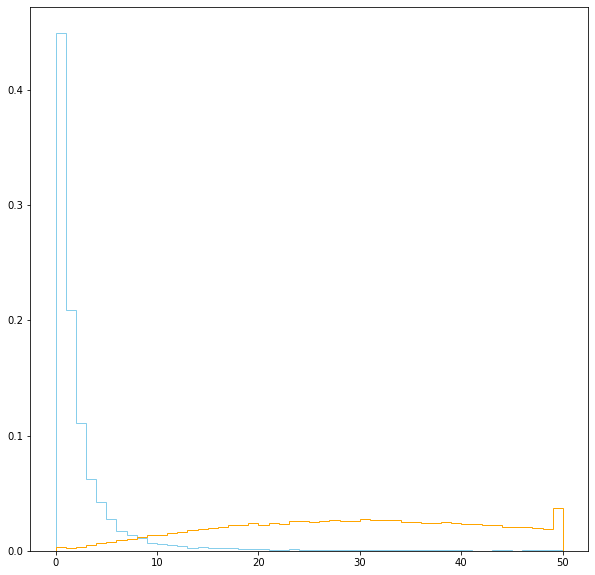

In [23]:
fig = plt.figure( figsize=(10,10) )
plt.hist( X_test[ "ExtraPfCands" ][ y_test_pred == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( X_test[ "ExtraPfCands" ][ y_test_pred == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

### Inspect signal and background sets

In [24]:
X_sig_scaled = None
X_bkg_scaled = None
y_sig_proba = None
y_sig_pred = None
y_bkg_proba = None
y_bkg_pred = None

if load_keras_model:
    X_sig_scaled = scaler.transform( X_sig )
    print( X_sig_scaled )
    X_bkg_scaled = scaler.transform( X_bkg )
    print( X_bkg_scaled )
    
    y_sig_proba = clf.predict( X_sig_scaled )
    y_sig_proba = y_sig_proba.flatten()
    y_sig_pred = ( y_sig_proba >= prob_cut ).astype( "int32" )
    y_sig_pred = y_sig_pred.flatten()
    
    y_bkg_proba = clf.predict( X_bkg_scaled )
    y_bkg_proba = y_bkg_proba.flatten()
    y_bkg_pred = ( y_bkg_proba >= prob_cut ).astype( "int32" )
    y_bkg_pred = y_bkg_pred.flatten()
else: 
    y_sig_proba = clf.predict_proba( X_sig )[:,1]
    y_sig_pred = clf.predict( X_sig )
    
    y_bkg_proba = clf.predict_proba( X_bkg )[:,1]
    y_bkg_pred = clf.predict( X_bkg )

print ( y_sig_proba )
print ( y_sig_pred )
print ( y_bkg_proba )
print ( y_bkg_pred )

print ( accuracy_score( y_sig, y_sig_pred ) )
print ( accuracy_score( y_bkg, y_bkg_pred ) )

[0.5105978  0.52671966 0.59487589 ... 0.54796243 0.55944238 0.53960229]
[1. 1. 1. ... 1. 1. 1.]
[0.15633481 0.14357693 0.17749703 ... 0.07211121 0.09215117 0.14362452]
[0. 0. 0. ... 0. 0. 0.]
0.9975131535679053
0.9999164678702317


(0.0, 0.15)

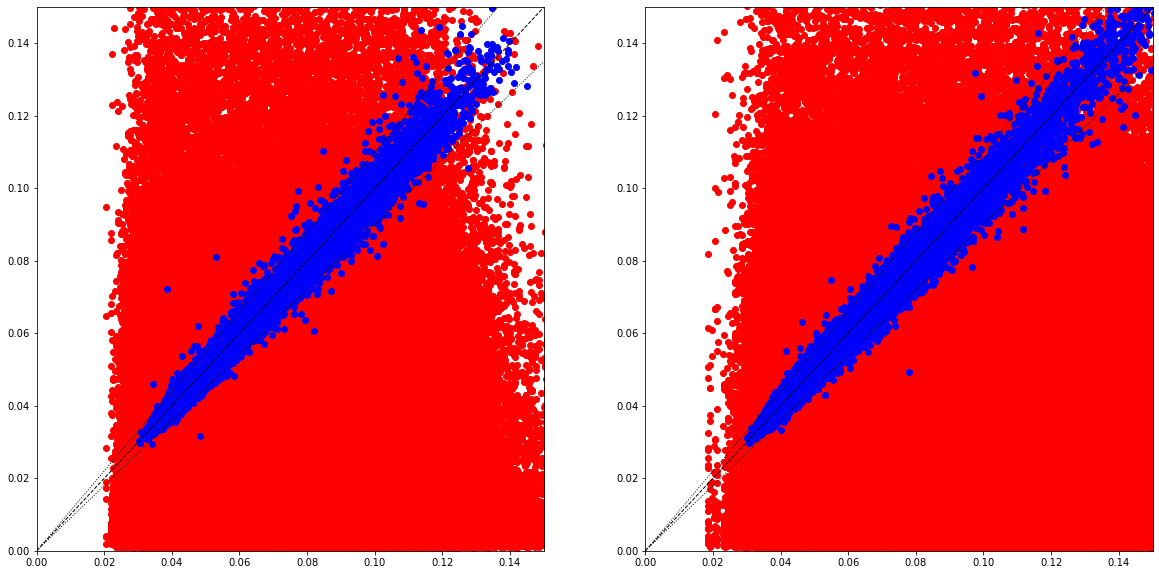

In [25]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_bkg[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( df_signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_bkg[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( df_signal[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )
    
axes[0].plot( df_bkg[ "Xi" ][ msk_bkg_1 ], df_bkg[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( df_signal[ "Xi" ][ msk_sig_1 ], df_signal[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_bkg[ "Xi" ][ msk_bkg_2 ], df_bkg[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( df_signal[ "Xi" ][ msk_sig_2 ], df_signal[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

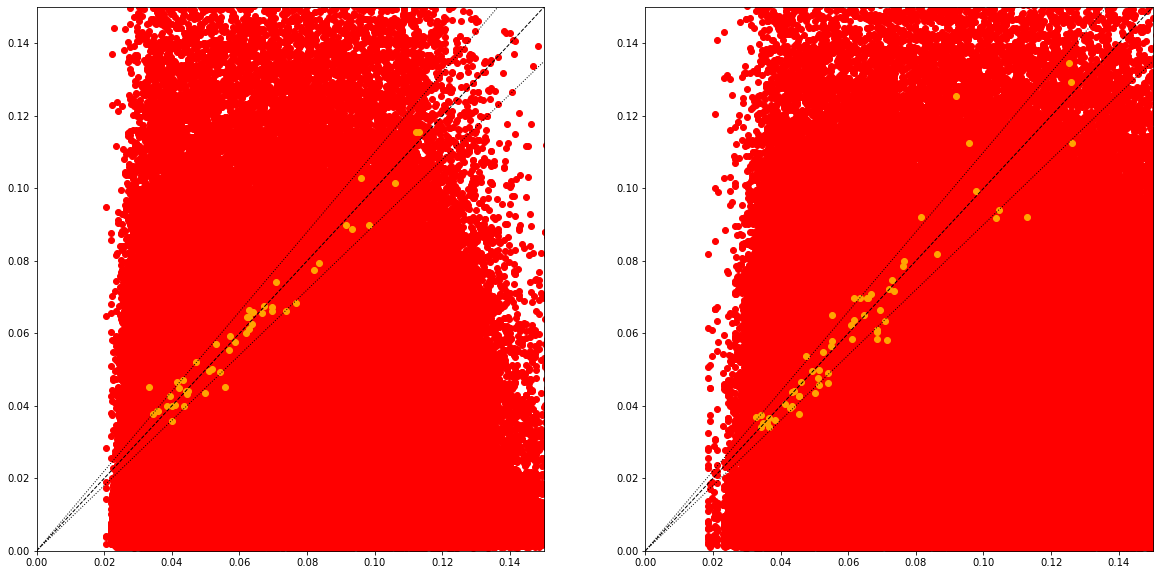

In [26]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_bkgerr_1 = None
msk_bkgerr_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_bkg[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_bkgerr_1 = ( df_bkg[ "RPId1" ] == 23 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( df_bkg[ "RPId1" ] == 123 ) & ( y_bkg_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_bkg[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_bkgerr_1 = ( df_bkg[ "Arm" ] == 0 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( df_bkg[ "Arm" ] == 1 ) & ( y_bkg_pred == 1 )
    
axes[0].plot( df_bkg[ "Xi" ][ msk_bkg_1 ], df_bkg[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( df_bkg[ "Xi" ][ msk_bkgerr_1 ], df_bkg[ "XiMuMuPlus" ][ msk_bkgerr_1 ], 'o', color='orange' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_bkg[ "Xi" ][ msk_bkg_2 ], df_bkg[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( df_bkg[ "Xi" ][ msk_bkgerr_2 ], df_bkg[ "XiMuMuMinus" ][ msk_bkgerr_2 ], 'o', color='orange' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

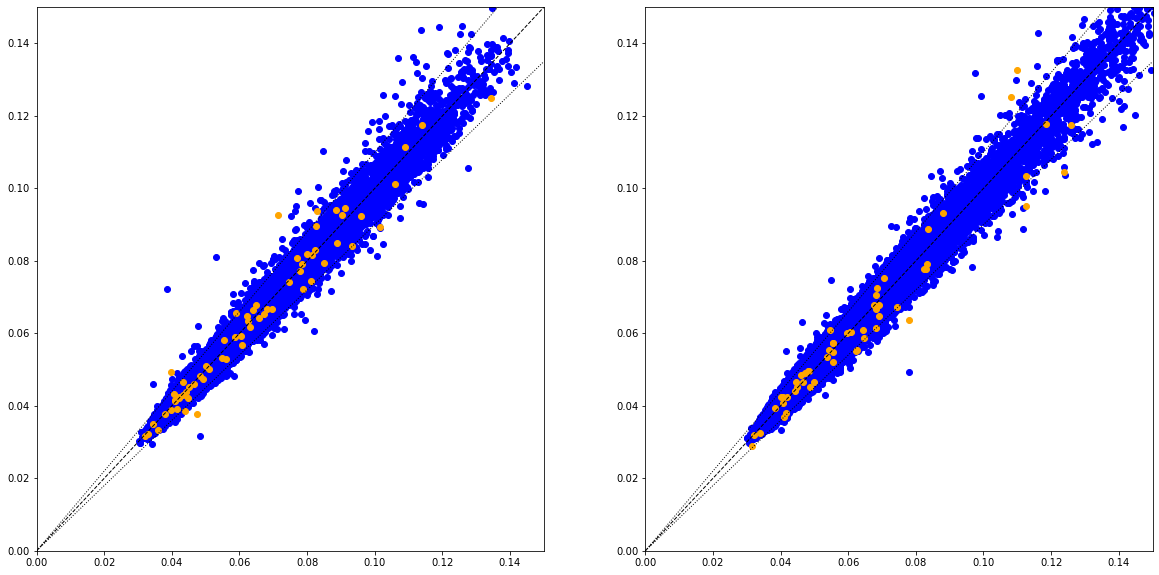

In [27]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_sigerr_1 = None
msk_sigerr_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_sigerr_1 = ( df_signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( df_signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 0 )
    msk_sig_1 = ( df_signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_sigerr_1 = ( df_signal[ "Arm" ] == 0 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( df_signal[ "Arm" ] == 1 ) & ( y_sig_pred == 0 )
    msk_sig_1 = ( df_signal[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )

axes[0].plot( df_signal[ "Xi" ][ msk_sig_1 ], df_signal[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( df_signal[ "Xi" ][ msk_sigerr_1 ], df_signal[ "XiMuMuPlus" ][ msk_sigerr_1 ], 'o', color='orange' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_signal[ "Xi" ][ msk_sig_2 ], df_signal[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( df_signal[ "Xi" ][ msk_sigerr_2 ], df_signal[ "XiMuMuMinus" ][ msk_sigerr_2 ], 'o', color='orange' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

## Data

In [29]:
fileNames_data = [
    'output/output-UL2017B-PreSel.h5',
    'output/output-UL2017C1-PreSel.h5',
    'output/output-UL2017E-PreSel.h5',
    'output/output-UL2017F1-PreSel.h5'
]

df_counts_data, df_data = get_data( fileNames_data )

output/output-UL2017B-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(107075, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.5000000e+01 8.6700000e+02 ... 1.3261172e-01
  1.9532344e-03 4.8346210e-02]
 [2.9722700e+05 5.5000000e+01 8.6700000e+02 ... 1.3261172e-01
  1.9532344e-03 4.8346210e-02]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0Pt',

[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muon0VtxZ', b'Muon1Pt', b'Muon1Eta', b'Muon1Phi', b'Muon1VtxZ', b'PrimVertexZ', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlus', b'XiMuMuMinus']
['Run', 'LumiSection', 'BX', 'EventNum', 'CrossingAngle', 'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2', 'Xi', 'T', 'ThX', 'ThY', 'Time', 'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP', 'Muon0Pt', 'Muon0Eta', 'Muon0Phi', 'Muon0VtxZ', 'Muon1Pt', 'Muon1Eta', 'Muon1Phi', 'Muon1VtxZ', 'PrimVertexZ', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus']
['All', 'Muon', 

In [30]:
df_data = process_data( df_data )
df_data[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
3,297227,55,38079656,120.0,1,1,103,123,4.577393,1.367676,...,-0.000014,0.0,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346,0.048346
6,297227,56,38791640,120.0,1,1,103,123,8.585938,2.644531,...,0.000024,0.0,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.062855
39,297227,71,50687028,120.0,1,0,3,23,5.214844,-0.371826,...,0.000093,0.0,126.357605,113.611771,270.992401,27,0.016921,0.010428,0.041786,0.010428
48,297227,73,52238048,120.0,1,1,103,123,5.372803,0.135132,...,0.000031,0.0,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333
51,297227,74,52411720,120.0,1,1,103,123,4.895752,-0.607605,...,0.000121,0.0,111.228539,96.216682,211.304825,37,0.308182,0.016115,0.019881,0.019881
61,297227,75,53449356,120.0,1,0,3,23,12.326172,-1.268066,...,0.000065,0.0,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.019344
70,297227,76,54126336,120.0,1,1,103,123,3.238647,1.550049,...,-0.000029,0.0,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.006129
73,297227,78,56185408,120.0,1,1,103,123,5.210449,-1.396362,...,0.000116,0.0,57.649437,56.255272,111.417343,25,0.141610,0.014498,0.005325,0.005325
101,297227,91,66200792,120.0,1,1,103,123,11.390625,4.910645,...,0.000011,0.0,73.228600,69.507820,143.137054,22,0.010714,0.009334,0.013000,0.013000
109,297227,94,68360752,120.0,1,0,3,23,5.153076,1.484619,...,-0.000047,0.0,82.481186,53.035610,110.397728,63,0.410358,0.090327,0.001269,0.090327


In [31]:
X_data = df_data[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
X_data[:20]

,Xi,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMu
3,0.067306,63.340645,62.493637,123.616516,27,0.132612,0.048346
6,0.102869,65.270454,65.022888,152.786011,29,0.058782,0.062855
39,0.039614,126.357605,113.611771,270.992401,27,0.016921,0.010428
48,0.052213,86.516212,56.114479,138.904510,10,0.060892,0.008333
51,0.045295,111.228539,96.216682,211.304825,37,0.308182,0.019881
61,0.104492,74.069061,62.750038,159.699677,53,0.023202,0.019344
70,0.055042,75.266441,69.694183,223.032425,59,0.145185,0.006129
73,0.056894,57.649437,56.255272,111.417343,25,0.141610,0.005325
101,0.122168,73.228600,69.507820,143.137054,22,0.010714,0.013000
109,0.052344,82.481186,53.035610,110.397728,63,0.410358,0.090327


In [32]:
X_data_scaled = None
y_data_proba = None
y_data = None

if load_keras_model:
    X_data_scaled = scaler.transform( X_data )
    print( X_data_scaled )
   
    y_data_proba = clf.predict( X_data_scaled )
    y_data_proba = y_data_proba.flatten()
    y_data = ( y_data_proba >= prob_cut ).astype( "int32" )
    y_data = y_data.flatten()
else:
    y_data_proba = clf.predict_proba( X_data )[:,1]
    y_data = clf.predict( X_data )

print ( y_data_proba )
print ( y_data )

[0.36947486 0.27747301 0.20287932 ... 0.06719369 0.07328732 0.15172167]
[0. 0. 0. ... 0. 0. 0.]


(0.0, 0.15)

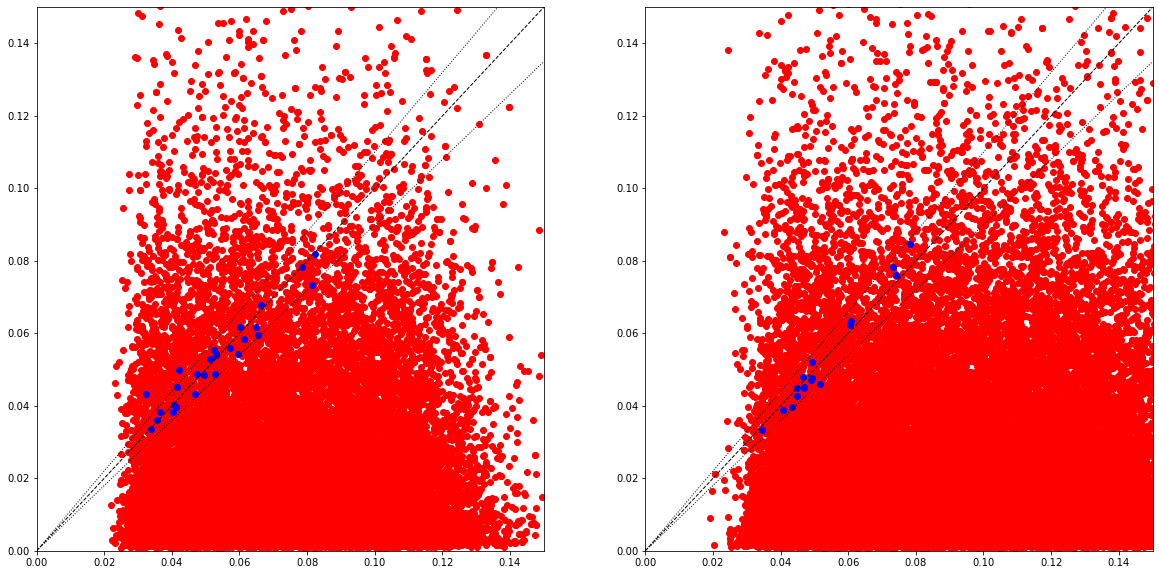

In [33]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 0 )
    msk_bkg_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 0 )
    msk_sig_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 1 )
    msk_sig_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_data[ "Arm" ] == 0 ) & ( y_data == 0 )
    msk_bkg_2 = ( df_data[ "Arm" ] == 1 ) & ( y_data == 0 )
    msk_sig_1 = ( df_data[ "Arm" ] == 0 ) & ( y_data == 1 )
    msk_sig_2 = ( df_data[ "Arm" ] == 1 ) & ( y_data == 1 )

axes[0].plot( df_data[ "Xi" ][ msk_bkg_1 ], df_data[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( df_data[ "Xi" ][ msk_sig_1 ], df_data[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_data[ "Xi" ][ msk_bkg_2 ], df_data[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( df_data[ "Xi" ][ msk_sig_2 ], df_data[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(array([60.14068777, 61.34887123, 62.42279845, 58.52978926, 60.00642333,
        53.69703874, 61.34890247, 53.56279615, 49.40127564, 59.73792083,
        53.83131267, 55.30791771, 52.75737127, 51.95191522, 58.39549564,
        58.93253432, 55.17367519, 55.71071012, 52.48882482, 53.56276497,
        54.5025895 , 53.42852245, 45.50821385, 50.74367208, 53.16016118,
        50.34094452, 46.85063903, 42.95770601, 43.36033355, 45.10548629,
        50.07245948, 43.09194884, 49.53548941, 48.46154926, 40.80972569,
        44.56861998, 47.65609414, 48.0588217 , 46.58226245, 47.65598319,
        42.82346318, 43.49467733, 37.85630214, 45.64256263, 43.62892016,
        43.628717  , 41.07830637, 40.27266185, 41.48103486, 39.33314956]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.01

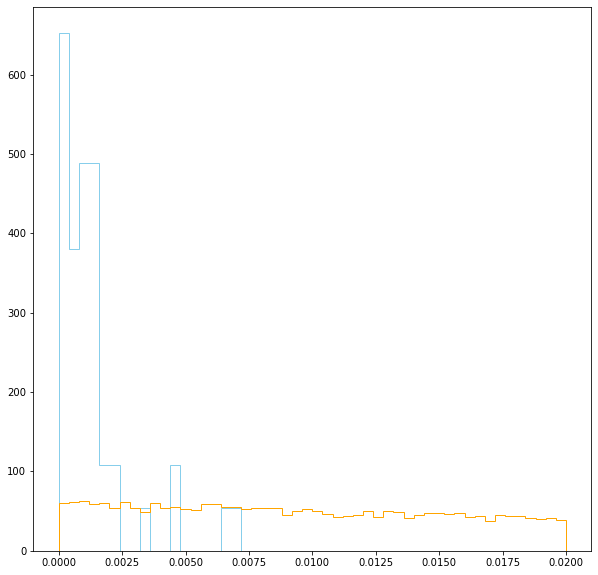

In [34]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "Acopl" ][ y_data == 1 ], histtype='step', color='skyblue', bins=50, range=(0.,0.02), density=True )
plt.hist( df_data[ "Acopl" ][ y_data == 0 ], histtype='step', color='orange', bins=50, range=(0.,0.02), density=True )

(array([0.00326585, 0.0025356 , 0.00365126, 0.00551747, 0.00677512,
        0.00835734, 0.00900645, 0.01016268, 0.01121749, 0.01344882,
        0.01363138, 0.01576129, 0.01578157, 0.01762749, 0.01825632,
        0.02083249, 0.02127875, 0.0224147 , 0.02217128, 0.025356  ,
        0.0230841 , 0.02440261, 0.02292182, 0.02432147, 0.02596454,
        0.0256197 , 0.02490973, 0.02614711, 0.02517344, 0.02576169,
        0.02557913, 0.02728305, 0.0262891 , 0.02639052, 0.025356  ,
        0.02584283, 0.02511258, 0.02464603, 0.02383464, 0.02411863,
        0.02336809, 0.02440261, 0.02200901, 0.02294211, 0.02119761,
        0.02083249, 0.02024423, 0.0200211 , 0.01805347, 0.03712118]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 1 Patch objects>)

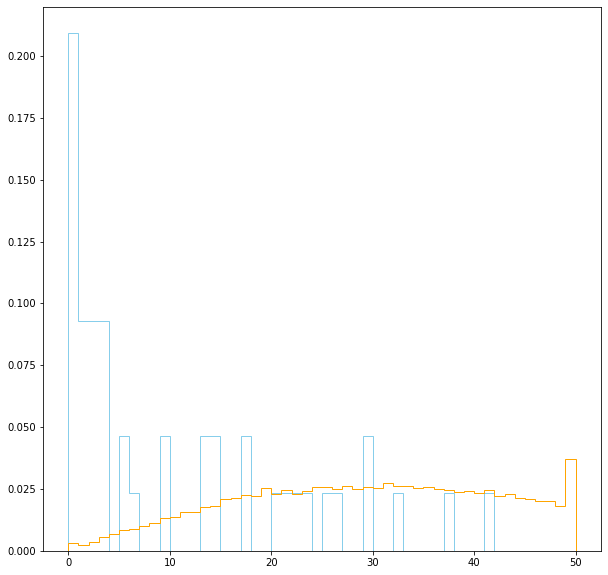

In [35]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "ExtraPfCands" ][ y_data == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( df_data[ "ExtraPfCands" ][ y_data == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

### Append data table with classifier prediction and probability

In [36]:
#vars_ = ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu']
#df_data[ "category" ] = clf.predict( df_data[ vars_ ] ).astype("int32")
#df_data[ "probability" ] = clf.predict_proba( df_data[ vars_ ] )[:,1]
df_data[ "category" ] = y_data
df_data[ "probability" ] = y_data_proba
df_data[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu,category,probability
3,297227,55,38079656,120.0,1,1,103,123,4.577393,1.367676,...,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346,0.048346,0.0,0.369475
6,297227,56,38791640,120.0,1,1,103,123,8.585938,2.644531,...,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.062855,0.0,0.277473
39,297227,71,50687028,120.0,1,0,3,23,5.214844,-0.371826,...,126.357605,113.611771,270.992401,27,0.016921,0.010428,0.041786,0.010428,0.0,0.202879
48,297227,73,52238048,120.0,1,1,103,123,5.372803,0.135132,...,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333,0.0,0.115215
51,297227,74,52411720,120.0,1,1,103,123,4.895752,-0.607605,...,111.228539,96.216682,211.304825,37,0.308182,0.016115,0.019881,0.019881,0.0,0.208402
61,297227,75,53449356,120.0,1,0,3,23,12.326172,-1.268066,...,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.019344,0.0,0.096924
70,297227,76,54126336,120.0,1,1,103,123,3.238647,1.550049,...,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.006129,0.0,0.182919
73,297227,78,56185408,120.0,1,1,103,123,5.210449,-1.396362,...,57.649437,56.255272,111.417343,25,0.141610,0.014498,0.005325,0.005325,0.0,0.161452
101,297227,91,66200792,120.0,1,1,103,123,11.390625,4.910645,...,73.228600,69.507820,143.137054,22,0.010714,0.009334,0.013000,0.013000,0.0,0.104362
109,297227,94,68360752,120.0,1,0,3,23,5.153076,1.484619,...,82.481186,53.035610,110.397728,63,0.410358,0.090327,0.001269,0.090327,0.0,0.156220


In [37]:
#df_bkg[ "category" ] = clf.predict( df_bkg[ vars_ ] ).astype("int32")
#df_bkg[ "probability" ] = clf.predict_proba( df_bkg[ vars_ ] )[:,1]
df_bkg[ "category" ] = y_bkg_pred
df_bkg[ "probability" ] = y_bkg_proba
df_bkg[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu,category,probability
10,297227,56,38791640,120.0,1,0,3,23,7.063232,1.953613,...,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.002211,0.0,0.156335
20,297227,58,40362008,120.0,1,0,3,23,7.391113,2.280518,...,80.369690,68.791176,228.323425,10,0.271141,0.028539,0.011619,0.028539,0.0,0.143577
33,297227,60,41478176,120.0,1,0,3,23,6.782959,1.464966,...,114.150841,93.884605,323.668549,40,0.157789,0.035037,0.018197,0.035037,0.0,0.177497
47,297227,63,44189296,120.0,1,0,3,23,13.382812,-1.072510,...,138.408752,108.538467,245.222839,53,0.008506,0.033806,0.010684,0.033806,0.0,0.102257
69,297227,73,52238048,120.0,1,1,103,123,8.629883,1.481323,...,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333,0.0,0.081928
84,297227,75,53449356,120.0,1,1,103,123,5.546875,1.592651,...,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.007848,0.0,0.126920
93,297227,76,54126336,120.0,1,0,3,23,8.200684,3.784912,...,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.049092,0.0,0.265836
111,297227,78,55898044,120.0,1,1,103,123,3.611084,1.855103,...,58.097786,53.140121,126.642601,84,0.273834,0.032531,0.003312,0.003312,0.0,0.113512
118,297227,79,56863080,120.0,1,1,103,123,3.396606,1.380615,...,61.966732,50.172760,127.597572,21,0.026694,0.001631,0.059633,0.059633,0.0,0.335270
138,297227,86,61943160,120.0,1,0,3,23,7.637451,1.072144,...,91.612099,71.395660,163.843567,62,0.095938,0.016999,0.009692,0.016999,0.0,0.095823


y max. = 7340.363514370717


(0.0, 50.0)

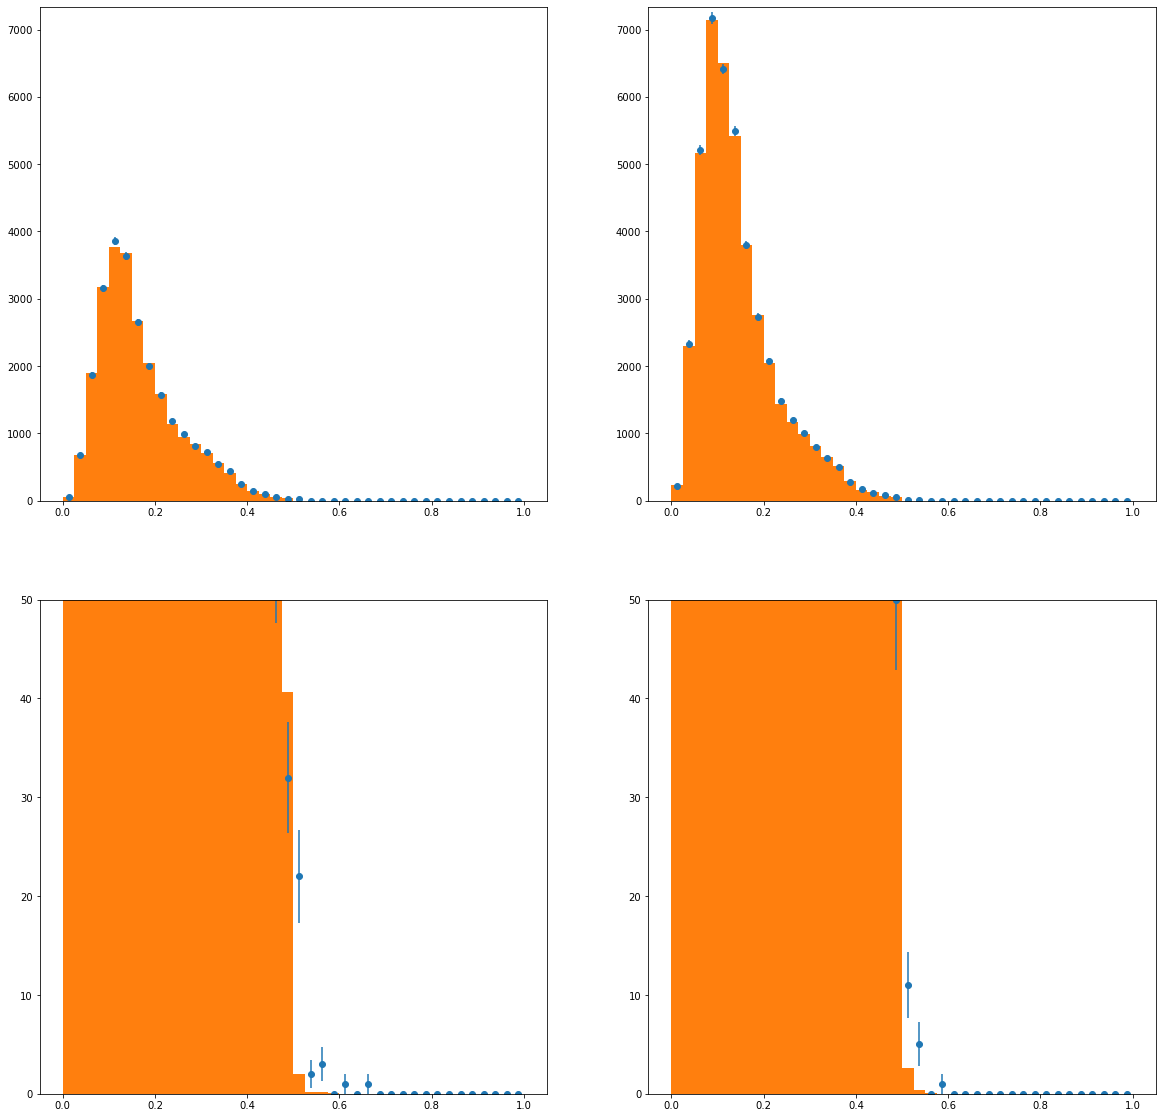

In [38]:
fig, axes = plt.subplots( 2, 2, figsize=(20,20) )

var_ = "probability"
bins_ = 40
range_ = (0.,1.)

msk_data_1 = None
msk_data_2 = None
if proton_selection == "SingleRP":
    msk_data_1 = ( df_data[ "RPId1" ] == 23 )
    msk_data_2 = ( df_data[ "RPId1" ] == 123 )
elif proton_selection == "MultiRP":
    msk_data_1 = ( df_data[ "Arm" ] == 0 )
    msk_data_2 = ( df_data[ "Arm" ] == 1 )
    
counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0,0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')
axes[1,0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[0,1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')
axes[1,1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

msk_bkg_pred_1 = None
msk_bkg_pred_2 = None
if proton_selection == "SingleRP":
    msk_bkg_pred_1 = ( df_bkg[ "RPId1" ] == 23 )
    msk_bkg_pred_2 = ( df_bkg[ "RPId1" ] == 123 )
elif proton_selection == "MultiRP":
    msk_bkg_pred_1 = ( df_bkg[ "Arm" ] == 0 )
    msk_bkg_pred_2 = ( df_bkg[ "Arm" ] == 1 )

weights_1 = None
if resample_factor > 1:
    weights_1 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_1 ], ( 1./resample_factor ) )

weights_2 = None
if resample_factor > 1:
    weights_2 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_2 ], ( 1./resample_factor ) )

axes[0,0].hist( df_bkg[ var_ ][ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )
axes[1,0].hist( df_bkg[ var_ ][ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )

axes[0,1].hist( df_bkg[ var_ ][ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )
axes[1,1].hist( df_bkg[ var_ ][ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )

axes[0,0].set_ylim( top=y_max )
axes[0,1].set_ylim( top=y_max )
#axes[0].set_yscale('log')
#axes[1].set_yscale('log')
axes[1,0].set_ylim( top=50. )
axes[1,1].set_ylim( top=50. )

### Plot events classified as signal

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

#var_ = "Xi"
#bins_ = 10
#range_ = (0.,0.2)

var_ = "ThX"
bins_ = 10
range_ = (-0.0005,0.0005)

#var_ = "ThY"
#bins_ = 10
#range_ = (-0.0005,0.0005)

#var_ = "T"
#bins_ = 10
#range_ = (-4.,0.)

#var_ = "Time"
#bins_ = 20
#range_ = (-0.5,0.5)

#var_ = "Muon0Pt"
#bins_ = 10
#range_ = (50.,200.)

#var_ = "InvMass"
#bins_ = 10
#range_ = (110.,500.)

#var_ = "Acopl"
#bins_ = 10
#range_ = (0.,0.01)

#var_ = "ExtraPfCands"
#bins_ = 20
#range_ = (0,20)

#prob_cut_sel = prob_cut
prob_cut_sel = 0.30

#msk_data_1 = ( df_data[ "category" ] == 1 )
#msk_data_2 = ( df_data[ "category" ] == 1 )
msk_data_1 = ( df_data[ "probability" ] >= prob_cut_sel )
msk_data_2 = ( df_data[ "probability" ] >= prob_cut_sel )
if proton_selection == "SingleRP":
    msk_data_1 = ( df_data[ "RPId1" ] == 23 ) & msk_data_1
    msk_data_2 = ( df_data[ "RPId1" ] == 123 ) & msk_data_2
elif proton_selection == "MultiRP":
    msk_data_1 = ( df_data[ "Arm" ] == 0 ) & msk_data_1
    msk_data_2 = ( df_data[ "Arm" ] == 1 ) & msk_data_2

counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

#msk_bkg_pred_1 = ( df_bkg[ "category" ] == 1 )
#msk_bkg_pred_2 = ( df_bkg[ "category" ] == 1 )
msk_bkg_pred_1 = ( df_bkg[ "probability" ] >= prob_cut_sel )
msk_bkg_pred_2 = ( df_bkg[ "probability" ] >= prob_cut_sel )
if proton_selection == "SingleRP":
    msk_bkg_pred_1 = ( df_bkg[ "RPId1" ] == 23 ) & msk_bkg_pred_1
    msk_bkg_pred_2 = ( df_bkg[ "RPId1" ] == 123 ) & msk_bkg_pred_2
elif proton_selection == "MultiRP":
    msk_bkg_pred_1 = ( df_bkg[ "Arm" ] == 0 ) & msk_bkg_pred_1
    msk_bkg_pred_2 = ( df_bkg[ "Arm" ] == 1 ) & msk_bkg_pred_2

weights_1 = None
if resample_factor > 1:
    weights_1 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_1 ], ( 1./resample_factor ) )

weights_2 = None
if resample_factor > 1:
    weights_2 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_2 ], ( 1./resample_factor ) )

axes[0].hist( df_bkg[ var_ ][ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )
axes[1].hist( df_bkg[ var_ ][ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )
    
axes[0].set_ylim( top=y_max )
axes[1].set_ylim( top=y_max )

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

bins_ = 20
range_ = (-1.,1.)

vals_data = ( 1. - df_data[ "Xi" ] / df_data[ "XiMuMu" ] )

counts_1, bin_edges_1 = np.histogram( vals_data[ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

counts_2, bin_edges_2 = np.histogram( vals_data[ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

vals_bkg = ( 1. - df_bkg[ "Xi" ] / df_bkg[ "XiMuMu" ] )

axes[0].hist( vals_bkg[ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )
axes[1].hist( vals_bkg[ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )
    
axes[0].set_ylim( top=y_max )
axes[1].set_ylim( top=y_max )

### References

In [ ]:
np.info( np.ndarray.flatten )